# Исследование надёжности заёмщиков

## Описание проекта
Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели кредитного скоринга — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Содержание:

* [1. Знакомство с данными.](#first_bullet)
* [2. Предобработка данных.](#second_bullet)
   * [2.1. Работа с пропущенными значениями.](#third_bullet)
   * [2.2. Удаление дубликатов.](#forth_bullet)
   * [2.3. Лемматизация данных.](#fifth_bullet)
   * [2.4. Категоризация данных в соответствии с поставленными вопросами.](#sixth_bullet)
* [3. Ответы на вопросы.](#seventh_bullet)
* [4. Общий вывод.](#eighth_bullet)

## 1. Знакомство с данными.<a id="first_bullet"></a>

Импортируем нужные библиотеки, считываем данные, оценим размер таблицы и типы данных.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
import math
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Считаем данные.

In [1]:
banks_customers = pd.read_csv('data.csv')
banks_customers_default = pd.read_csv('data.csv') 

Посмотрим первые строки датасета.

In [159]:
banks_customers.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Посмотрим размер датасета.

In [160]:
banks_customers.shape

(21525, 12)

Посмотрим общую информацио о таблице.

In [161]:
banks_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Таблица размерностью 21525 на 12. В полях _**days_employed**_ и _**total_income**_ вещественные числа, а также есть отрицательные значения. Разница в количестве значений в этих полях указывает на наличие Nan.

## 2. Предобработка данных.<a id="second_bullet"></a>

## 2.1. Работа с пропущенными значениями. <a id="third_bullet"></a> 

Сразу бросается в глаза одинаковое к-во строк в полях days_employed и total_income. Подозреваем, что пропуски содержатся в одних и тех же строках. Проверяем это, отсортировав поле total_income методом isnull(), выводим обшую информацию о получившемся датафрейме.

In [162]:
Nans_in_rows = banks_customers[banks_customers.total_income.isnull()]
Nans_in_rows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2174 entries, 12 to 21510
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          2174 non-null   int64  
 1   days_employed     0 non-null      float64
 2   dob_years         2174 non-null   int64  
 3   education         2174 non-null   object 
 4   education_id      2174 non-null   int64  
 5   family_status     2174 non-null   object 
 6   family_status_id  2174 non-null   int64  
 7   gender            2174 non-null   object 
 8   income_type       2174 non-null   object 
 9   debt              2174 non-null   int64  
 10  total_income      0 non-null      float64
 11  purpose           2174 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 220.8+ KB


Значение 0 в полях days_employed и total_income означает то, что пропуски находятся на одних и тех же строках.

In [163]:
Nans_in_rows.groupby('income_type')['income_type'].count()

income_type
госслужащий         147
компаньон           508
пенсионер           413
предприниматель       1
сотрудник          1105
Name: income_type, dtype: int64

Сгруппировав клиентов по типу занятости, видим явную ошибку выгрузки, так как значения пропущены у клиентов, у которых должны быть и общий трудовой стаж, и ежемесячный доход.

Для дальнейшего анализа нам необходимо заполнить пропуски на характерные значения, для начала детальнее взглянем на имеющиеся данные.

In [164]:
#проанализируем значения стажа без пропусков детальнее, отфильтруем и добавим их в переменную customers_without_nan
customers_without_nan = banks_customers[banks_customers['days_employed'].notna()].\
sort_values(by='days_employed',ascending=False).reset_index()

#отрицательные значения явная ошибка - возмем значения по модулю, изменим тип на целочисленный
customers_without_nan.days_employed = abs(customers_without_nan.days_employed.astype(int)) 

#отсортируем и посмотрим максимальные значения стажа
customers_without_nan[['days_employed','dob_years','income_type']].head(10)

,days_employed,dob_years,income_type
0,401755,56,пенсионер
1,401715,69,пенсионер
2,401675,61,пенсионер
3,401674,60,пенсионер
4,401663,61,пенсионер
5,401635,56,пенсионер
6,401619,63,пенсионер
7,401614,59,пенсионер
8,401591,56,пенсионер
9,401590,58,пенсионер


<AxesSubplot:>

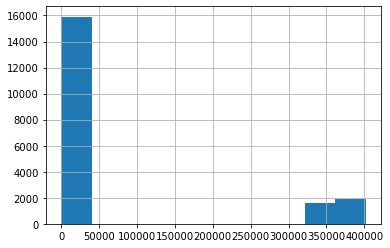

In [165]:
#посмотрим данные на гистограмме распределения
customers_without_nan['days_employed'].hist(bins=10)

Мы видим, что в поле _days_employed_ есть аномально высокие значения. 401755 при переводе в года составляет примерно 1100 лет.
Посмотрим количество таких аномалий, выведем их долю от тотал. На гистограме мы видим, что все эти значения превышают 300000, отфильтруем по этому признаку.

In [166]:
abnormal_values = banks_customers[banks_customers['days_employed']>300000]['days_employed'].count()
abnormal_percent = abnormal_values/21525 
print('Количество аномальных значений:',abnormal_values)
print('Процент аномальных от общей выборки: {:.0%}'.format(abnormal_percent))

Количество аномальных значений: 3445
Процент аномальных от общей выборки: 16%


Взглянем, как аномалии распределяются по возрасту и типу занятости.

<AxesSubplot:xlabel='dob_years'>

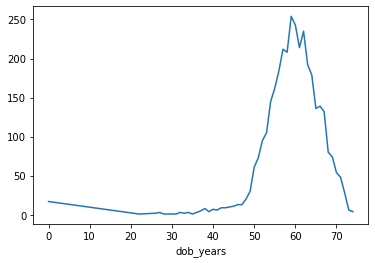

In [167]:
banks_customers[banks_customers['days_employed']>300000].groupby('dob_years')['dob_years'].count().plot()

In [168]:
banks_customers[banks_customers['days_employed']>300000].groupby('income_type')['dob_years'].count()

income_type
безработный       2
пенсионер      3443
Name: dob_years, dtype: int64

Ошибка наиболее часто возникает у пенсионеров. 
**16%** - большая доля от выборки, значения нельзя просто так удалять. 
Предположим, что ошибка заключается в том, что стаж тут указан не в днях, а в часах. 
Тогда максимально значение 401755 будет примерно равнятся 46 годам.

Преобразуем аномальные значения в дни. Напишем функцию correction и методом apply применим её к days_employed. Функция будет принимать аргументом значение поля и преобразовывать его в дни в случае аномальных значений.

In [169]:
def correction(days_employed):
    if days_employed > 300000:
        return int(days_employed / 24)
    else:
        return days_employed

In [170]:
customers_without_nan['correct_days_employed'] = customers_without_nan['days_employed'].apply(correction)

In [171]:
customers_without_nan['correct_days_employed'].sort_values(ascending=False).reset_index(drop=True).head(10)

0    18388
1    17615
2    16739
3    16738
4    16736
5    16736
6    16735
7    16734
8    16734
9    16733
Name: correct_days_employed, dtype: int64

Отлично, аномально высоких значений теперь нет. Теперь проверим, есть ли аномально низкие.
Отсортируем данные по возрастанию.

In [172]:
customers_without_nan[['correct_days_employed','dob_years','income_type']].\
sort_values(by='correct_days_employed',ascending=True).reset_index(drop=True).head(10)

,correct_days_employed,dob_years,income_type
0,24,31,сотрудник
1,24,32,сотрудник
2,30,47,компаньон
3,33,43,сотрудник
4,34,31,компаньон
5,37,36,сотрудник
6,39,34,госслужащий
7,46,33,сотрудник
8,47,49,сотрудник
9,50,43,компаньон


Видим маленький стаж у людей, у которых он явно должен быть больше.
Отфильтруем стаж до года и посмотрим, как он распределяется по возрасту и типу занятости.

<AxesSubplot:xlabel='dob_years'>

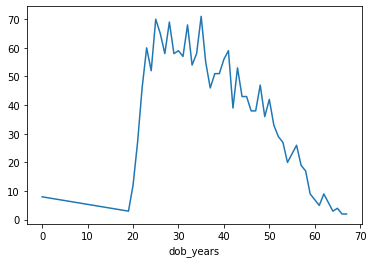

In [173]:
customers_without_nan[customers_without_nan['correct_days_employed'] < 365].\
groupby('dob_years')['dob_years'].count().plot()

In [174]:
customers_without_nan[customers_without_nan['correct_days_employed'] < 365].groupby('income_type')['income_type'].count()

income_type
госслужащий      94
компаньон       604
сотрудник      1129
Name: income_type, dtype: int64

Налицо ещё одна ошибка в данном поле - большое к-во людей разных возрастов и типов занятости имеют очень маленький трудовой стаж. Сложно определить природу ошибки, так как и по возрасту, и по типу занятости много клиентов с, возможно, некорректным значением рабочего стажа.

В данной ситуации я бы связался с коллегами из банка и уточнил бы корректность выгрузки. 

Ну а пока продолжим делать анализ согласно задаче. В дальнейшем, получив более точные данные, мы сможем подставить их в данный расчет и получить более корректные выводы.

Так как days_employed - количественная переменная, заменим пропуски в days_employed _характерными значениями_. Так как мы избавились от аномалий, которые искажали бы статистику по столбцу, для замены пропусков воспользуемся средним значением.

In [175]:
days_employed_mean = customers_without_nan['correct_days_employed'].mean()
print('Среднее:',round(days_employed_mean))

Среднее: 4641


In [176]:
banks_customers.days_employed = banks_customers.days_employed.fillna(days_employed_mean)
banks_customers.days_employed = abs(banks_customers.days_employed.astype(int)) 
banks_customers['days_employed'] = banks_customers['days_employed'].apply(correction)
banks_customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  int64  
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


Разберемся с пропусками в **total_income**.

In [177]:
total_income_mean = banks_customers[banks_customers['total_income'].notna()]['total_income'].mean()
total_income_median = banks_customers[banks_customers['total_income'].notna()]['total_income'].median()
total_income_max = banks_customers['total_income'].max()
total_income_min = banks_customers['total_income'].min()

print('Максимальное значение дохода: {:.0f}'.format(total_income_max))
print('Минимальное значение дохода:{:.0f}'.format(total_income_min))
print()
print('Среднее', total_income_mean)
print('Медиана', total_income_median)

Максимальное значение дохода: 2265604
Минимальное значение дохода:20667

Среднее 167422.3022081719
Медиана 145017.93753253992


Построим на графике распределение клиентов в зависимости от зарплат.

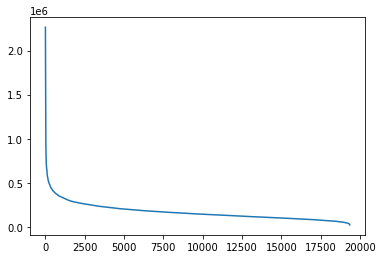

In [178]:
income = banks_customers['total_income'].sort_values(ascending=False).reset_index(drop=True).plot()

Разница в минимальном и максимальном значении довольно большая, люди с очень высоким доходом могут несколько искажать картину, если мы возьмём среднее значение. Для замены пропусков используем медиану.

Так как в нашей выборке клиенты имеют разные типы занятости и, как следствие, разные уровни дохода. Выделим медианные значения в каждой группе и заменим ими пропуски.

In [179]:
# определим медианы в зависимости от типа занятости 
median_by_types = banks_customers.groupby('income_type')['total_income'].median().\
    to_frame().reset_index().rename(columns={'total_income':'median_by_types'})

In [180]:
median_by_types

,income_type,median_by_types
0,безработный,131339.751676
1,в декрете,53829.130729
2,госслужащий,150447.935283
3,компаньон,172357.950966
4,пенсионер,118514.486412
5,предприниматель,499163.144947
6,сотрудник,142594.396847
7,студент,98201.625314


In [181]:
# добавим поле с медианами в датасет
banks_customers = banks_customers.merge(median_by_types, on='income_type', how='outer')

In [182]:
# напишем функцию для подстановки медианы вместо пропуска
def nan_replacement(row):
    total_income = row['total_income']
    median_by_types = row['median_by_types']
    if math.isnan(total_income):
        return median_by_types
    else:
        return total_income

In [183]:
# добавим поле new_total_income в котором применим функцию и заменим пропуски медианами
banks_customers['new_total_income'] = banks_customers.apply(nan_replacement, axis=1)
# удалим лишние поля
banks_customers['total_income'] = banks_customers['new_total_income']
banks_customers = banks_customers.drop(columns=['new_total_income','median_by_types'])
# преобразуем total_income в int, округлив методом round()
banks_customers.total_income = banks_customers.total_income.round().astype(int)

In [184]:
banks_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   children          21525 non-null  int64 
 1   days_employed     21525 non-null  int64 
 2   dob_years         21525 non-null  int64 
 3   education         21525 non-null  object
 4   education_id      21525 non-null  int64 
 5   family_status     21525 non-null  object
 6   family_status_id  21525 non-null  int64 
 7   gender            21525 non-null  object
 8   income_type       21525 non-null  object
 9   debt              21525 non-null  int64 
 10  total_income      21525 non-null  int64 
 11  purpose           21525 non-null  object
dtypes: int64(7), object(5)
memory usage: 2.1+ MB


Проверим на корректность поле **dob_years**, кажется, там тоже есть проблемы.

In [185]:
banks_customers = banks_customers.sort_values(by='dob_years').reset_index(drop=True)
banks_customers.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,731,0,высшее,0,в разводе,3,F,сотрудник,0,247541,покупка жилья
1,0,3218,0,высшее,0,женат / замужем,0,M,сотрудник,0,162427,операции с жильем
2,0,866,0,высшее,0,гражданский брак,1,M,компаньон,0,287173,сыграть свадьбу
3,1,223,0,неоконченное высшее,2,гражданский брак,1,M,сотрудник,0,256071,сыграть свадьбу
4,0,14796,0,среднее,1,вдовец / вдова,2,F,пенсионер,0,54816,образование


In [186]:
print('Меньше 18 лет:',banks_customers[banks_customers['dob_years'] < 18]['dob_years'].count())
print('Возраст 0 лет:',banks_customers[banks_customers['dob_years'] == 0]['dob_years'].count())

Меньше 18 лет: 101
Возраст 0 лет: 101


0 лет - это явно некорректное значение, таких клиентов меньше 1% выборки. Можем удалить их, чтобы они не искажали анализ.

In [187]:
banks_customers = banks_customers.drop(banks_customers[banks_customers['dob_years'] == 0].index).reset_index(drop=True)
print('Меньше 18 лет:',banks_customers[banks_customers['dob_years'] < 18]['dob_years'].count())
print('Возраст 0 лет:',banks_customers[banks_customers['dob_years'] == 0]['dob_years'].count())

Меньше 18 лет: 0
Возраст 0 лет: 0


## Вывод

Обнаружено 2174 значения Nan в полях _days_employed_ и _total_income_ , определено, что пропуски находятся в одних и тех же строках. Причиной пропусков может быть ошибка при выгрузке данных.

В поле _days_employed_ найдены аномально большие и отрицательные значения, приведены в нормальный вид, согласно гипотезе, что большие значения - измерены в часах, а отрицательные - очередная ошибка выгрузки.

Вещественные значения в полях _days_employed_ и _total_income_ заменены на целочисленные при помощи метода astype().

Пропущенные значения в _days_employed_ и _total_income_ заменены на среднее значение и медиану соответственно. Медиана в _total_income_ выбрана во избежания искажения статистики по причине очень высокого дохода у отдельной части выборки.

Также во избежание искажения выводов из выборки удалена 101 строка, содержащая значения возраста равное 0. 

Один из основных выводов данного шага - выгрузка имеет большое количество ошибок. Необходимо дать обратную связь коллегам из банка для их проработки. Ошибки могут негативно влиять на дальнейшие выводы и точность модели кредитного скоринга.

## 2.2. Удаление дубликатов. <a id="fourth_bullet"></a>

Проверим исходную таблицу banks_customers_default на дубли

In [188]:
banks_customers_default['duplicates'] = banks_customers_default.duplicated()

In [189]:
duplicates = banks_customers_default[banks_customers_default['duplicates'] == True]['duplicates'].count()
print('Количество полных дубликатов:', duplicates)

Количество полных дубликатов: 54


In [190]:
banks_customers_default[banks_customers_default['duplicates'] == True].sort_values(by='dob_years')

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,duplicates
19321,0,NaN,23,среднее,1,Не женат / не замужем,4,F,сотрудник,0,NaN,сделка с подержанным автомобилем,True
18328,0,NaN,29,высшее,0,женат / замужем,0,M,сотрудник,0,NaN,покупка жилой недвижимости,True
21281,1,NaN,30,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,покупка коммерческой недвижимости,True
18349,1,NaN,30,высшее,0,женат / замужем,0,F,госслужащий,0,NaN,покупка жилья для семьи,True
13878,1,NaN,31,среднее,1,женат / замужем,0,F,компаньон,0,NaN,покупка жилья,True
16904,1,NaN,32,высшее,0,женат / замужем,0,F,сотрудник,0,NaN,на покупку подержанного автомобиля,True
4182,1,NaN,34,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,NaN,свадьба,True
9238,2,NaN,34,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,покупка жилья для сдачи,True
13773,0,NaN,35,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,сыграть свадьбу,True
14432,2,NaN,36,высшее,0,женат / замужем,0,F,госслужащий,0,NaN,получение образования,True


После проверки методом duplicated() было найдено 54 дублирующихся значения. 
Как видно, это те значения, в которых отсутствуют данные в полях days_employed и total_income.
Так как в выгрузки нет поля с id пользователя, а также отсутствуют данные в полях о стаже и доходе, мы не можем с уверенностью сказать, что эти наблюдения являются полными дубликатами, и удалить их.


Проверим уникальные значения в полях с категорийными переменными: education, family_status, gender, income_type

Вызовем метод unique() и посмотрим на поле education.

In [191]:
banks_customers['education'].unique()

array(['среднее', 'неоконченное высшее', 'СРЕДНЕЕ', 'Неоконченное высшее',
       'высшее', 'Среднее', 'НЕОКОНЧЕННОЕ ВЫСШЕЕ', 'ВЫСШЕЕ', 'Высшее',
       'начальное', 'Начальное', 'НАЧАЛЬНОЕ', 'ученая степень',
       'УЧЕНАЯ СТЕПЕНЬ', 'Ученая степень'], dtype=object)

Видим, что некоторые значения дублируются, но находятся в разных регистрах, переведем все значения поля education в нижний регистр.

In [192]:
banks_customers['education'] = banks_customers['education'].str.lower()

In [193]:
# уникальные значения поля family_status
banks_customers['family_status'].unique()

array(['гражданский брак', 'женат / замужем', 'Не женат / не замужем',
       'в разводе', 'вдовец / вдова'], dtype=object)

In [194]:
# уникальные значения поля income_type
banks_customers['gender'].unique()

array(['M', 'F', 'XNA'], dtype=object)

Gender xna явно не существует(пока). Посмотрим, сколько строк имеют такое значение.

In [195]:
banks_customers[banks_customers['gender'] == 'XNA']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
857,0,2358,24,неоконченное высшее,2,гражданский брак,1,XNA,компаньон,0,203905,покупка недвижимости


Нашлась одна строка со значением XNA, так как по представленным данным мы не можем определить пол человека, удалим данную строку.

In [196]:
banks_customers = banks_customers.drop(banks_customers[banks_customers['gender'] == 'XNA'].index).reset_index(drop=True)

In [197]:
# уникальные значения поля income_type с учетом удаления XNA
banks_customers['gender'].unique()

array(['M', 'F'], dtype=object)

In [198]:
# уникальные значения поля income_type
banks_customers['income_type'].unique()

array(['компаньон', 'сотрудник', 'госслужащий', 'студент', 'пенсионер',
       'предприниматель', 'безработный', 'в декрете'], dtype=object)

In [199]:
# уникальные значения поля children
banks_customers['children'].unique()

array([ 0,  1,  2, 20,  3, -1,  4,  5])

In [200]:
banks_customers.groupby('children')['children'].count()

children
-1        47
 0     14079
 1      4802
 2      2042
 3       328
 4        41
 5         9
 20       75
Name: children, dtype: int64

Как видно, в данных есть одна явная ошибка - значение -1. Также крайне вероятна ошибка в значении 20, скорее всего, ноль тут лишний. Исправим обнаруженные ошибки: -1 заменим на 1, а 20 заменим на 2.

In [201]:
banks_customers.loc[(banks_customers['children'] == -1), 'children'] = 1
banks_customers.loc[(banks_customers['children'] == 20), 'children'] = 2

Объединим клиентов в две категории категории С детьми и Без детей , для этого напишем функцию having_children, которая будет принимать аргументом значение поля children.

In [202]:
def having_children(children):
    if children > 0:
        return 'С детьми'
    else:
        return 'Без детей'

In [203]:
banks_customers['having_children'] = banks_customers['children'].apply(having_children)

In [204]:
banks_customers.groupby('children')['children'].count()

children
0    14079
1     4849
2     2117
3      328
4       41
5        9
Name: children, dtype: int64

## Вывод

Исходный датасет проверен на полные дубликаты, найдены 54 значения с совпадающими данными. 
Из-за отсутствия id пользователя, нельзя со 100% уверенностью говорить о том, что наблюдения в действительности являются дубликатами, а не записями с совпадающими параметрами.

В столбце _education_ обнаружены одинаковые категории клиентов, записанные в разном регистре. Методом .str.lower() значения преведены к одному регистру.

В поле _gender_ найдено и удалено значение XNA, из-за невозможности причислить его к какому либо полу.

В поле _children_ найдены и обработаны ошибки некорректные значения -1 И 20.

Значения, дублирующие друг друга по смыслу, есть в поле _purpose_ , их лемматизация и группировка по категориям будет проведена в следующем шаге.



## 2.3. Лемматизация данных. <a id="fifth_bullet"></a>

В рамках проекта мы можем использовать лемматизацию для разделения целей получения кредита на более понятные категории.
Для начала отсортируем уникальные значения поля _purpose_.

In [205]:
purpose_unique = banks_customers['purpose'].unique()
purpose_unique

array(['на проведение свадьбы', 'покупка жилья для сдачи',
       'покупка недвижимости', 'высшее образование', 'ремонт жилью',
       'свой автомобиль', 'операции со своей недвижимостью', 'автомобили',
       'операции с коммерческой недвижимостью',
       'покупка коммерческой недвижимости',
       'на покупку подержанного автомобиля', 'сыграть свадьбу',
       'сделка с автомобилем', 'операции с жильем',
       'профильное образование', 'получение образования',
       'на покупку своего автомобиля',
       'получение дополнительного образования', 'жилье', 'недвижимость',
       'покупка жилья', 'покупка жилой недвижимости', 'свадьба',
       'получение высшего образования', 'на покупку автомобиля',
       'строительство жилой недвижимости', 'покупка своего жилья',
       'сделка с подержанным автомобилем', 'покупка жилья для семьи',
       'автомобиль', 'заняться высшим образованием',
       'строительство собственной недвижимости', 'заняться образованием',
       'строительство нед

Выделим леммы в целях, которые указали клиенты, и определим основные цели получения кредита.

In [206]:
m = Mystem() 

In [207]:
%%time
k = []
for i in range(len(purpose_unique)):
    lemma = m.lemmatize(purpose_unique[i])
    k.append(lemma)
    print(lemma)

['на', ' ', 'проведение', ' ', 'свадьба', '\n']
['покупка', ' ', 'жилье', ' ', 'для', ' ', 'сдача', '\n']
['покупка', ' ', 'недвижимость', '\n']
['высокий', ' ', 'образование', '\n']
['ремонт', ' ', 'жилье', '\n']
['свой', ' ', 'автомобиль', '\n']
['операция', ' ', 'со', ' ', 'свой', ' ', 'недвижимость', '\n']
['автомобиль', '\n']
['операция', ' ', 'с', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['покупка', ' ', 'коммерческий', ' ', 'недвижимость', '\n']
['на', ' ', 'покупка', ' ', 'подержать', ' ', 'автомобиль', '\n']
['сыграть', ' ', 'свадьба', '\n']
['сделка', ' ', 'с', ' ', 'автомобиль', '\n']
['операция', ' ', 'с', ' ', 'жилье', '\n']
['профильный', ' ', 'образование', '\n']
['получение', ' ', 'образование', '\n']
['на', ' ', 'покупка', ' ', 'свой', ' ', 'автомобиль', '\n']
['получение', ' ', 'дополнительный', ' ', 'образование', '\n']
['жилье', '\n']
['недвижимость', '\n']
['покупка', ' ', 'жилье', '\n']
['покупка', ' ', 'жилой', ' ', 'недвижимость', '\n']
['свадьба', '\n']


Основными категориями причин оказались:
    * Покупка/строительство/ремонт недвижимости
    * Покупка/сделка с автомобилем
    * Празднование свадьбы
    * Образование
    
Пропишем условие и сопоставим полученные категории целям, которые указали клиенты занесем в датафрейм _purpose_categories_.

In [208]:
l = []
for i in k:
    if 'недвижимость' in i or 'жилье' in i:
        l.append('Покупка/строительство/ремонт недвижимости')
    elif 'автомобиль' in i:
        l.append('Покупка/сделка с автомобилем')
    elif 'свадьба' in i:
        l.append('Празднование свадьбы')
    elif 'образование' in i:
        l.append('Образование')        
        
purpose_categories = pd.DataFrame(list(zip(purpose_unique,l)),columns=['purpose','purpose_category'])

In [209]:
purpose_categories

,purpose,purpose_category
0,на проведение свадьбы,Празднование свадьбы
1,покупка жилья для сдачи,Покупка/строительство/ремонт недвижимости
2,покупка недвижимости,Покупка/строительство/ремонт недвижимости
3,высшее образование,Образование
4,ремонт жилью,Покупка/строительство/ремонт недвижимости
5,свой автомобиль,Покупка/сделка с автомобилем
6,операции со своей недвижимостью,Покупка/строительство/ремонт недвижимости
7,автомобили,Покупка/сделка с автомобилем
8,операции с коммерческой недвижимостью,Покупка/строительство/ремонт недвижимости
9,покупка коммерческой недвижимости,Покупка/строительство/ремонт недвижимости


Добавим категории из purpose_categories в датасет banks_customers при помощи метода merge

In [210]:
banks_customers = banks_customers.merge(purpose_categories, on='purpose', how='outer')

In [211]:
banks_customers.groupby('purpose_category')['purpose_category'].count().sort_values(ascending=False)

purpose_category
Покупка/строительство/ремонт недвижимости    10792
Покупка/сделка с автомобилем                  4293
Образование                                   4004
Празднование свадьбы                          2334
Name: purpose_category, dtype: int64

## Вывод

Метод лемматизации позволил выделить отдельные категории целей получения кредита, благодаря чему можно увидеть, что чаще всего клиенты берут кредит на **Покупка/строительство/ремонт недвижимости**.


## 2.4. Категоризация данных. <a id="sixth_bullet"></a>

Так как нам предстоит выявить зависимость возврата кредита в срок у разных категорий клиентов, определим средний процент клиентов, имеющих задолженность по всей выборке.

In [212]:
#Определим средий процент клиентов, которые имели задолженность по кредиту
debt_persent = banks_customers.debt.agg({'family_status': 'count','debt': 'sum'}).to_frame()
debt_persent = debt_persent.iloc[1,0] / debt_persent.iloc[0,0]
print('Средний процент клиентов с задолженностью {:.2%}'.format(debt_persent))

Средний процент клиентов с задолженностью 8.09%


Для дальнейшего анализа и ответа на вопросы произведем категоризацию клиентов банка по требуемым параметрам, а именно:
* Наличие детей
* Семейное положение
* Уровень дохода
* Цели кредита

#### Категоризация по наличию детей 

Посмотрим, какой процент клиентов имели задолженность по кредиту в зависимости от наличия детей, агрегируем данные и  сделаем датафрейм, в котором будут поля:
* having_children - признак наличия детей, 
* count_of_customers - количесто клиентов всего, 
* count_of_debtor - количество должников, 
* debtors_part - доля клиентов имевших задолженность


In [213]:
#проагрегируем данные
having_children_dependence = banks_customers.groupby('having_children').agg({'having_children': 'count','debt': 'sum'}).\
    rename(columns={'having_children':'count_of_customers', 'debt':'count_of_debtor' }).reset_index()
#добавим долю клиентов имевших задолженность
having_children_dependence['debtors_part'] \
    = round(having_children_dependence['count_of_debtor'] / having_children_dependence['count_of_customers'] * 100, 2)

In [214]:
having_children_dependence

,having_children,count_of_customers,count_of_debtor,debtors_part
0,Без детей,14079,1058,7.51
1,С детьми,7344,675,9.19


Также для понимания того, как влияет к-во детей на возврат кредита, выделим категории - без детей, 1-2 ребенка, больше двух детей.
Сделаем функцию number_of_children, добавим признак в датасет и выведем сводную таблицу.

In [215]:
def number_of_children(children):
    if children > 2:
        return 'больше двух детей'
    elif children == 0:
        return 'без детей'
    elif children == 1:
        return 'один ребенок'
    else:
        return 'два ребенка'

In [216]:
banks_customers['number_of_children'] = banks_customers['children'].apply(number_of_children)

In [217]:
#проагрегируем данные
number_children_dependence = banks_customers.groupby('number_of_children').agg({'number_of_children': 'count','debt': 'sum'}).\
    rename(columns={'number_of_children':'count_of_customers', 'debt':'count_of_debtor' }).reset_index()
#добавим долю клиентов, имевших задолженность
number_children_dependence['debtors_part'] \
    = round(number_children_dependence['count_of_debtor'] / number_children_dependence['count_of_customers'] * 100, 2)

In [218]:
number_children_dependence

,number_of_children,count_of_customers,count_of_debtor,debtors_part
0,без детей,14079,1058,7.51
1,больше двух детей,378,31,8.20
2,два ребенка,2117,202,9.54
3,один ребенок,4849,442,9.12


#### Категоризация по семейному положению

Сделаем категоризацию в зависимости от семейного положения. Сгруппируем данные по категориям:
* Не женат / не замужем
* в разводе
* вдовец / вдова
* гражданский брак
* женат / замужем	

In [219]:
family_status_dependence = banks_customers.groupby('family_status').agg({'family_status': 'count','debt': 'sum'})\
    .rename(columns={'family_status':'count_of_customers', 'debt':'count_of_debtor' }).reset_index()
family_status_dependence['debtors_part'] \
    = round(family_status_dependence['count_of_debtor'] / family_status_dependence['count_of_customers'] * 100, 2)

In [220]:
family_status_dependence = family_status_dependence.sort_values('debtors_part')
family_status_dependence

,family_status,count_of_customers,count_of_debtor,debtors_part
2,вдовец / вдова,955,62,6.49
1,в разводе,1185,85,7.17
4,женат / замужем,12331,927,7.52
3,гражданский брак,4155,386,9.29
0,Не женат / не замужем,2797,273,9.76


#### Категоризация по уровню дохода

Сделаем категоризацию в зависимости от уровня дохода

Для того, чтобы понять, как распределяется выборка по уровню дохода, посмотрим квантили распределения. Округлим цифры для понятного визуального восприятия и разобьем на категории, как в предыдущих шагах.

In [221]:
print(round(banks_customers['total_income'].quantile(0.166)))
print(round(banks_customers['total_income'].quantile(0.333)))
print(round(banks_customers['total_income'].quantile(0.498)))
print(round(banks_customers['total_income'].quantile(0.666)))
print(round(banks_customers['total_income'].quantile(0.833)))

92164
119222
142594
172358
228488


In [222]:
def total_income_category(total_income):
    if total_income >= 230000.0:
        return '>230000'
    elif total_income >= 170000.0:
        return '170000 - 230000'
    elif total_income >= 140000.0:
        return '140000 - 170000'
    elif total_income >= 120000.0:
        return '120000 - 140000'
    elif total_income >= 90000.0:
        return '90000 - 120000' 
    else:
        return '20000 - 90000'

In [223]:
banks_customers['total_income_category'] = banks_customers['total_income'].apply(total_income_category)

In [224]:
total_income_dependence = banks_customers.groupby('total_income_category')\
    .agg({'total_income_category': 'count','debt': 'sum'})\
    .rename(columns={'total_income_category':'count_of_customers', 'debt':'count_of_debtor' }).reset_index()
total_income_dependence['debtors_part'] \
    = round(total_income_dependence['count_of_debtor'] / total_income_dependence['count_of_customers'] * 100, 2)

In [225]:
total_income_dependence = total_income_dependence.sort_values(by='debtors_part').reset_index(drop=True)
total_income_dependence

,total_income_category,count_of_customers,count_of_debtor,debtors_part
0,>230000,3499,242,6.92
1,20000 - 90000,3331,262,7.87
2,170000 - 230000,4188,333,7.95
3,90000 - 120000,3887,321,8.26
4,120000 - 140000,2252,194,8.61
5,140000 - 170000,4266,381,8.93


#### Категоризация по целям получения кредита

Проведем категоризацию в зависимости от целей получения кредита.
В датасете уже есть поле purpose_category, добавленное в рамках шага по лемматизации, сгруппируем данные и выявим зависимость, как в предыдущих шагах

In [226]:
purpose_category_dependence = banks_customers.groupby('purpose_category')\
    .agg({'purpose_category': 'count','debt': 'sum'})\
    .rename(columns={'purpose_category':'count_of_customers', 'debt':'count_of_debtor' }).reset_index()
purpose_category_dependence['debtors_part'] \
    = round(purpose_category_dependence['count_of_debtor'] / purpose_category_dependence['count_of_customers'] * 100, 2)

In [227]:
purpose_category_dependence = purpose_category_dependence.sort_values(by='debtors_part').reset_index(drop=True)
purpose_category_dependence

,purpose_category,count_of_customers,count_of_debtor,debtors_part
0,Покупка/строительство/ремонт недвижимости,10792,779,7.22
1,Празднование свадьбы,2334,184,7.88
2,Образование,4004,370,9.24
3,Покупка/сделка с автомобилем,4293,400,9.32


## Вывод

Теперь клиенты разбиты на конкретные категории. Осталось сделать выводы о полученных данных и ответить на вопросы, поставленные банком

## 3. Ответы на вопросы. <a id="seventh_bullet"></a>

Ответим на поставленные вопросы:
    * Есть ли зависимость между наличием детей и возвратом кредита в срок?
    * Есть ли зависимость между семейным положением и возвратом кредита в срок?
    * Есть ли зависимость между уровнем дохода и возвратом кредита в срок?
    * Как разные цели кредита влияют на его возврат в срок?

In [228]:
number_children_dependence

,number_of_children,count_of_customers,count_of_debtor,debtors_part
0,без детей,14079,1058,7.51
1,больше двух детей,378,31,8.20
2,два ребенка,2117,202,9.54
3,один ребенок,4849,442,9.12


Для оценки зависимости между наличием детей и возвратом кредита в срок, клиенты были разбиты на категории - клиенты с детьми и клиенты без детей, выявлена закономерность - если дети есть, то вероятность возникновения задолженности выше.

Анализ клиентов в зависимости от количества детей показал, что самый низкий показатель задолженности у клиентов без детей - это может быть обусловлено тем, что у таких клиентов меньше расходы и больше свободного времени, соответственно, им легче своевременно погашать кредиты.

Самый высокий показатель задолженности у клиентов с 1-2 детьми, у них больше расходы, но ещё пока нет особых льгот от государства для многодетных семей.

В свою очередь, многодетные клиенты чуть более ответственно относятся к погашению кредита, также они получают льготы от государства. В случае 3 и более детей, шанс выше, что большая часть из них запланирована - это значит, что клиенты осознанно относятся и к планированию семейного бюджета.



In [229]:
family_status_dependence

,family_status,count_of_customers,count_of_debtor,debtors_part
2,вдовец / вдова,955,62,6.49
1,в разводе,1185,85,7.17
4,женат / замужем,12331,927,7.52
3,гражданский брак,4155,386,9.29
0,Не женат / не замужем,2797,273,9.76


Видим, что наиболее ответственными заемщиками оказались либо те, кто состоят в браке, либо те, кто его пережил. Наверное, брак действительно дисциплинирует. Скорее всего, большая часть вдовцов и людей в разводе - уже взрослые, состоявшиеся финансово, осознанные клиенты.

Женатые/замужние люди находятся посередине - с одной стороны, у них есть поддержка супруга, но, с другой стороны, как правило, уровень затрат возрастает (появляются дети, жилье, средства передвижения и т.д.).

Самый большой процент задолженности наблюдается у неженатых/незамужних клиентов - есть вероятность, что многие из данной категории людей ещё молоды и не стабильны финансово, и в связи с семейным положением не могут рассчитывать на помощь супруга. Отчасти это также применимо и к гражданскому браку. 

In [230]:
total_income_dependence

,total_income_category,count_of_customers,count_of_debtor,debtors_part
0,>230000,3499,242,6.92
1,20000 - 90000,3331,262,7.87
2,170000 - 230000,4188,333,7.95
3,90000 - 120000,3887,321,8.26
4,120000 - 140000,2252,194,8.61
5,140000 - 170000,4266,381,8.93


Клиенты, которые больше всех зарабатывают, являются самыми надёжными заёмщиками - наличие высокого дохода и, как следствие, свободных денег позволяет им легко вносить ежемесячные платежи вовремя.

Клиенты с наименьшим уровнем дохода не имеют много свободных денег, но в то же время обычно не берут кредиты на большие суммы, поэтому платить вовремя посильные суммы им не так сложно. 

Клиенты со средним заработком от 90000 до 170000 могут получить кредиты на дорогостоящие товары или услуги. Но у данной категории людей также есть и свои риски, к примеру, предприниматели могут иметь не всегда стабильный бизнес. 

Также с ростом доходов повышается и потребность в символах статуса, которыми принято обладать, а это приводит к лишним затратам, оказывающимися на самом деле не по карману, как пример - дорогие автомобили, дорогой отдых, одежда люксовых брендов и т.д.

In [231]:
purpose_category_dependence

,purpose_category,count_of_customers,count_of_debtor,debtors_part
0,Покупка/строительство/ремонт недвижимости,10792,779,7.22
1,Празднование свадьбы,2334,184,7.88
2,Образование,4004,370,9.24
3,Покупка/сделка с автомобилем,4293,400,9.32


Самыми надежными оказались заемщики, которые покупают недвижимость и играют свадьбы. 

Наверное, это обусловлено тем, что покупка недвижимости - важный и хорошо обдуманный шаг. Также это может быть коммерческая недвижимость или жильё для сдачи в аренду, которые приносят клиенту доход. 

Празднование свадьбы может окупиться за счет подаренных денег, а суммы на подобные кредиты не очень большие в сравнении с кредитами на недвижимость или авто.

Кредит на образование - это чаще всего долгосрочное инвестирование, не всегда приносящее высокий доход сразу. За счет этого срок выплат растягивается.

Покупка автомобиля в кредит связана со многими рисками. К сумме кредита также добавляется стоимость обслуживания и починки в случае ДТП или поломки. 


## Общие выводы <a id="eighth_bullet"></a>

Целью проекта было выявления зависимости - влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок.

Входные данные от банка — статистика о платёжеспособности клиентов.

Проведена предобработка данных:
* Обнаружено 2174 пропущенных значения, причиной пропусков могла быть ошибка при выгрузке данных.
* В поле со стажем найдены аномально большие и отрицательные значения, приведены в нормальный вид, согласно гипотезе, что большие значения - измерены в часах, а отрицательные - ошибка выгрузки данных.
* Вещественные значения в полях со стажем и доходом заменены на целочисленные, а пропущенные значения в этих же полях заменены на среднее значение и медиану соответственно.
* Также во избежание искажения выводов из выборки удалена 101 строка, содержащая значения возраста равное 0.  

Основной вывод предобработки данных - выгрузка имеет большое количество ошибок. Необходимо дать обратную связь коллегам из банка для их проработки. Ошибки могут негативно влиять на дальнейшие выводы и точность модели кредитного скоринга.

В среднем процент клиентов, имевших задолженность составляет 8.09%. 
Для ответа на вопросы о зависимостях нам понадобилось разбить клиентов на разные категории.

Для оценки зависимости между количеством детей и возвратом кредита в срок, клиенты были разбиты на категории:
* Без детей
* Один ребенок
* Два ребенка 
* Больше двух детей

Анализ данных категорий показал, что самый низкий показатель задолженности у клиентов без детей 7.51% - это может быть обусловлено тем, что у таких клиентов меньше расходы и больше свободного времени, соответственно, им легче своевременно погашать кредит.

Самый высокий показатель задолженности у клиентов с одним ребенком - 9.12% и с двумя детьми - 9.54%, у таких клиентов могут быть больше расходы, но ещё пока нет особых льгот от государства для многодетных семей.

В свою очередь, многодетные клиенты чуть более ответственно относятся к погашению кредита - 8.20%. 
Такие клиенты могут получать льготы от государства. В случае 3 и более детей, шанс выше, что большая часть из них запланирована - это значит, что клиенты осознанно относятся к планированию как семьи, так и семейного бюджета.

Для анализа зависимости между семейным положением и возвратом кредита в срок, клиенты были разбиты на категории:
* вдовец / вдова
* в разводе
* женат / замужем	
* гражданский брак	
* женат / замужем

Анализ показал, что наиболее ответственными заемщиками вдовцы - 6.49% и люди в разводе - 7.17%. 
Скорее всего, большая часть вдовцов и людей в разводе - уже взрослые, состоявшиеся финансово, осознанные клиенты.

Женатые/замужние люди находятся посередине 7.52%.С одной стороны, у них есть поддержка супруга, но, с другой стороны, как правило, уровень затрат возрастает (появляются дети, жилье, средства передвижения и т.д.).

Самый большой процент задолженности наблюдается у неженатых/незамужних клиентов 9.76%.
Есть вероятность, что многие из данной категории людей ещё молоды и не стабильны финансово, и в связи с семейным положением не могут рассчитывать на помощь супруга. 

Поставленная цель была выполнена, выявлены и описаны закономерности влияния семейного положения и количества детей клиента на факт погашения кредита, это поможет банку выстроить эффективную модель кредитного скоринга.







In [ ]:
users ['name']